## Embedding MLP 

In [333]:
from __future__ import print_function, division
from tensorboardX import SummaryWriter
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

### Get training and test sample, remove unused columns

In [4]:
folder_path = "/home/leon/Documents/SparrowRecSys/src/main/resources/webroot/sampledata"

In [5]:
training_path = folder_path + "/trainingSamples/trainingSamples_D_S/trainingSamples.csv"

In [18]:
test_path = folder_path + "/testSamples/testSamples_D_S/testSamples.csv"

In [37]:
training_df = pd.read_csv(training_path, index_col=False)

In [38]:
test_df = pd.read_csv(test_path, index_col=False)

In [39]:
training_df.head()

,movieId,userId,rating,timestamp,label,releaseYear,movieGenre1,movieGenre2,movieGenre3,movieRatingCount,...,userGenre3,userGenre4,userGenre5,scaledReleaseYear,scaledmovieRatingCount,scaledmovieAvgRating,scaledmovieRatingStddev,scaleduserRatingCount,scaleduserAvgRating,scaleduserRatingStddev
0,593,10096,4.0,954365552,1,1991.0,13,4,12,13692.0,...,17,12,0,0.915493,0.936777,0.906250,0.449735,0.030612,0.688889,0.279874
1,832,10351,3.0,851791379,0,1996.0,13,12,0,3052.0,...,5,12,13,0.985916,0.208758,0.649306,0.486773,0.112245,0.726667,0.229560
2,85,10351,3.0,851791395,0,1995.0,11,5,0,592.0,...,5,12,13,0.971831,0.040438,0.690972,0.502645,0.122449,0.713333,0.229560
3,588,10351,5.0,851792205,1,1992.0,3,15,18,8980.0,...,12,5,13,0.929577,0.614369,0.729167,0.486773,0.224490,0.675555,0.207547
4,370,1090,2.0,1117852491,0,1994.0,2,7,0,3087.0,...,0,0,0,0.957747,0.211153,0.482639,0.555555,0.030612,0.200000,0.204403


In [40]:
columns2Keep = ['userId', 'userGenre1', 'userGenre2',  'userGenre3','userGenre4', 'userGenre5', 'scaleduserRatingCount',
       'scaleduserAvgRating', 'scaleduserRatingStddev', 'movieId',  'movieGenre1', 'movieGenre2', 'movieGenre3', 'scaledReleaseYear', 'scaledmovieRatingCount', 'scaledmovieAvgRating',
       'scaledmovieRatingStddev']

In [41]:
training_feature = training_df[columns2Keep]

In [42]:
training_feature.head()

,userId,userGenre1,userGenre2,userGenre3,userGenre4,userGenre5,scaleduserRatingCount,scaleduserAvgRating,scaleduserRatingStddev,movieId,movieGenre1,movieGenre2,movieGenre3,scaledReleaseYear,scaledmovieRatingCount,scaledmovieAvgRating,scaledmovieRatingStddev
0,10096,13,11,17,12,0,0.030612,0.688889,0.279874,593,13,4,12,0.915493,0.936777,0.906250,0.449735
1,10351,11,7,5,12,13,0.112245,0.726667,0.229560,832,13,12,0,0.985916,0.208758,0.649306,0.486773
2,10351,11,7,5,12,13,0.122449,0.713333,0.229560,85,11,5,0,0.971831,0.040438,0.690972,0.502645
3,10351,11,7,12,5,13,0.224490,0.675555,0.207547,588,3,15,18,0.929577,0.614369,0.729167,0.486773
4,1090,0,0,0,0,0,0.030612,0.200000,0.204403,370,2,7,0,0.957747,0.211153,0.482639,0.555555


In [43]:
training_label = training_df['label']

In [44]:
training_label.head()

0    1
1    0
2    0
3    1
4    0
Name: label, dtype: int64

In [45]:
test_feature = test_df[columns2Keep]

In [50]:
test_label = test_df['label']

In [118]:
torch.tensor(training_feature.iloc[0, :])[[0, 1, 5]]

tensor([10096.,    13.,     0.], dtype=torch.float64)

In [123]:
training_feature.columns

Index(['userId', 'userGenre1', 'userGenre2', 'userGenre3', 'userGenre4',
       'userGenre5', 'scaleduserRatingCount', 'scaleduserAvgRating',
       'scaleduserRatingStddev', 'movieId', 'movieGenre1', 'movieGenre2',
       'movieGenre3', 'scaledReleaseYear', 'scaledmovieRatingCount',
       'scaledmovieAvgRating', 'scaledmovieRatingStddev'],
      dtype='object')

### Data exploration

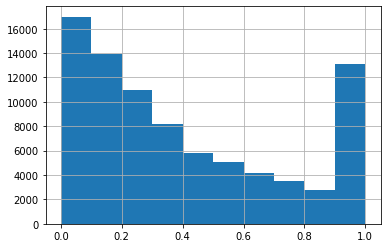

In [92]:
hist = training_feature['scaleduserRatingCount'].hist()

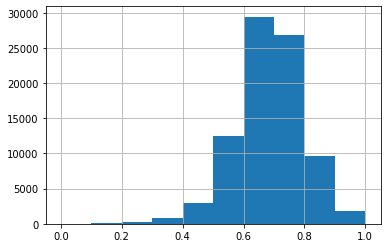

In [93]:
hist = training_feature['scaleduserAvgRating'].hist()

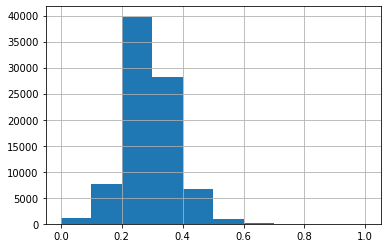

In [94]:
hist = training_feature['scaleduserRatingStddev'].hist()

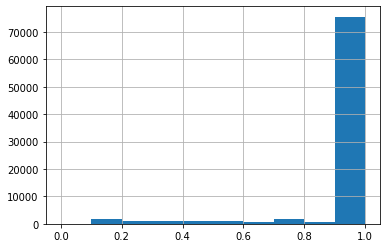

In [95]:
hist = training_feature['scaledReleaseYear'].hist()

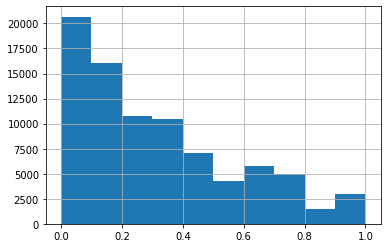

In [96]:
hist = training_feature['scaledmovieRatingCount'].hist()

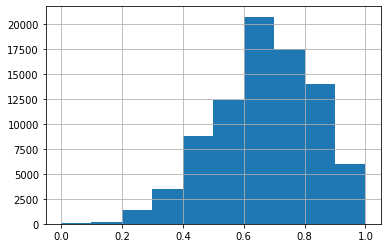

In [97]:
hist = training_feature['scaledmovieAvgRating'].hist()

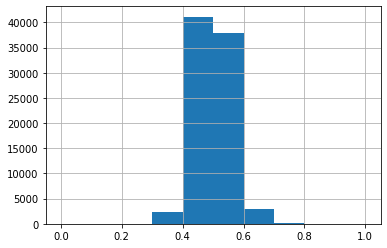

In [98]:
hist = training_feature['scaledmovieRatingStddev'].hist()

### DataSet and DataLoader

In [240]:
class ModelDataSet(Dataset):
    # Retrieve an item in every call
    def __init__(self, input_DF, label_DF):
        self.df = input_DF.astype(np.float32) # IMPORTANT
        self.label = label_DF.astype(np.float32)  # IMPORTANT
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        feature = torch.tensor(self.df.iloc[idx, :])
        label = torch.tensor(self.label.iloc[idx])
        return {'Feature': feature, 'Label': label}

In [241]:
training_dataset = ModelDataSet(training_feature, training_label)

In [248]:
test_dataset = ModelDataSet(test_feature, test_label)

In [242]:
BATCH_SIZE = 100

In [325]:
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [326]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Model and loss function

In [224]:
sparse_col = [0, 1, 2, 3, 4, 5, 9, 10, 11, 12] # column_index of sparse features

In [225]:
dense_col = [6, 7, 8, 13, 14, 15, 16]

In [226]:
sparse_col_size = [30001, 20, 20, 20, 20, 20, 1001, 20, 20, 20] # number of classes per sparse_feature

In [327]:
class MLP(nn.Module):
    def __init__(self, sparse_col, dense_col, sparse_col_size):
        super().__init__()
        self.sparse_col = sparse_col
        self.dense_col = dense_col
        self.sparse_col_size = sparse_col_size
        
        # For categorical features, we embed the features in dense vectors of dimension of 6 * category cardinality^1/4
        embedding_size = list(map(lambda x: int(6 * pow(x, 0.25)), self.sparse_col_size))
        
        # Create embedding layer for all sparse features
        sparse_embedding_list = []
        for class_size, embed_size in zip(self.sparse_col_size, embedding_size):
            sparse_embedding_list.append(nn.Embedding(class_size, embed_size, scale_grad_by_freq=True))
        self.sparse_embedding_layer = nn.ModuleList(sparse_embedding_list)
        
        # cal total embedding size 
        total_embedding_size = np.sum(embedding_size) + len(self.dense_col)
        
        # MLP linear layers
        self.linear1 = nn.Linear(total_embedding_size, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 1) # last layer
        
    def forward(self, feature):
        feature = feature.view(-1, 17) # convert to 2D tensor if batch_number == 1
        sparse_feature = feature[:, self.sparse_col].to(torch.long) # batch x feature #
        dense_feature = feature[:, self.dense_col]
        embedding_list = []
        for i in range(len(self.sparse_col)):
            sparse_feature_input = sparse_feature[:, i] # batch x 1
            embedding_layer = self.sparse_embedding_layer[i]
            embedding_output = embedding_layer(sparse_feature_input) # batch x 1 x embedding_size
            embedding_list.append(embedding_output.squeeze(1)) # batch x embedding_size
        embedding = torch.cat(embedding_list, dim=1) # batch x sum(embedding_size)
        embedding = torch.cat([embedding, dense_feature], dim=1) # batch x (sum(embedding_size)+dense_feature_size)
        output = F.relu(self.linear1(embedding)) # batch x 128
        output = F.relu(self.linear2(output)) # batch x 128
        output = F.sigmoid(self.linear3(output)) # batch x 1
        return output.view(-1) # batch
        

### Training and evaluation

In [253]:
from sklearn.metrics import roc_auc_score

In [328]:
model = MLP(sparse_col, dense_col,  sparse_col_size)

In [319]:
loss_fn = nn.BCELoss()

In [299]:
EPOCHS = 5

In [300]:
LR = 0.001

In [329]:
optimizer = optim.Adam(model.parameters(), lr=LR)

In [321]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [303]:
# summary = SummaryWriter()

In [330]:
class Train_Eval():
    def __init__(self, model, loss_fn, optim, device, train_dataloader, test_dataloader):
        self.device = device
        self.model = model.to(self.device)
        self.optim = optim
        self.loss_fn = loss_fn
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.threashold = 0.5 # threashold for positive class
        
    def train(self, epochs):
        self.model.train()
        for epoch in range(epochs):
            print("==========================================================")
            print("start training epoch: {}".format(epoch+1))
            loss_list = []
            pred_list = []
            label_list = []
            
            iteration = 1
            for train_data in self.train_dataloader:
                feature = train_data['Feature'].to(self.device)
                label = train_data['Label'].to(self.device)
                prediction = self.model(feature)
                
                pred_list.extend(prediction.tolist())
                label_list.extend(label.tolist())
                
                cur_loss = self.loss_fn(prediction, label)
                loss_list.append(cur_loss.item())
                cur_loss.backward()
                self.optim.step()
                self.optim.zero_grad()
                
                # logging every 20 iteration
                if iteration % 20 == 0:
                    print("---------------------------------------------------------")
                    print("epoch {}/{}, cur_iteration is {}, logloss is {:.2f}"
                          .format(epoch+1, epochs, iteration, cur_loss.item()))
                iteration += 1
                
            # validation every epoch
            training_loss, training_accuracy, training_roc_score = self._getMetric(loss_list, pred_list, label_list)
            print("==========================================================")
            print("Result of epoch {}".format(epoch+1))
            print(f"training loss: {training_loss:.2f}, accuracy: {training_accuracy:.3f}, roc_score: {training_roc_score:.2f}")
            
            test_loss, test_accuracy, test_roc_score = self.eval()
            print(f"test loss: {test_loss:.2f}, accuracy: {test_accuracy:.3f}, roc_score: {test_roc_score:.2f}")
            # summary.add_embedding(np.reshape(np.array(loss_list), (1, -1)), tag="loss_list")
            # summary.add_embedding(np.reshape(np.array(pred_list), (1, -1)), tag="pred_list")
            # summary.add_embedding(np.reshape(np.array(label_list), (1, -1)), tag="label_list")
            # summary.add_scalar("training_loss", training_loss)
            # summary.add_scalar("training_accuracy", training_accuracy)
            # summary.add_scalar("training_roc_score", training_roc_score)
    
    def eval(self):
        # return logloss, accuracy, roc_score
        self.model.eval()
        loss_list = []
        pred_list = []
        label_list = []
        with torch.no_grad():
            for test_data in self.test_dataloader:
                feature = test_data['Feature'].to(self.device)
                label = test_data['Label'].to(self.device)
                prediction = self.model(feature)
                cur_loss = self.loss_fn(prediction, label)
                
                loss_list.append(cur_loss.item())
                pred_list.extend(prediction.tolist())
                label_list.extend(label.tolist())
        return self._getMetric(loss_list, pred_list, label_list)
                
    def _getMetric(self, loss_list, pred_list, label_list):
        # return logloss, accuracy, roc_score        
        # average logloss
        avg_loss = np.mean(loss_list)
        # roc_score
        roc_score = roc_auc_score(label_list, pred_list)
        # average accuracy
        pred_class_list = list(map(lambda x: 1 if x >= self.threashold else 0, pred_list))
        correct_count = 0
        for p, l in zip(pred_class_list, label_list):
            if p == l:
                correct_count += 1
        avg_accuracy = correct_count / len(label_list)
        
        return avg_loss, avg_accuracy, roc_score

In [331]:
train_eval = Train_Eval(model, loss_fn, optimizer, dev, training_dataloader, test_dataloader)

In [332]:
train_eval.train(EPOCHS)

start training epoch: 1
---------------------------------------------------------
epoch 1/5, cur_iteration is 20, logloss is 0.68
---------------------------------------------------------
epoch 1/5, cur_iteration is 40, logloss is 0.68
---------------------------------------------------------
epoch 1/5, cur_iteration is 60, logloss is 0.67
---------------------------------------------------------
epoch 1/5, cur_iteration is 80, logloss is 0.65
---------------------------------------------------------
epoch 1/5, cur_iteration is 100, logloss is 0.62
---------------------------------------------------------
epoch 1/5, cur_iteration is 120, logloss is 0.64
---------------------------------------------------------
epoch 1/5, cur_iteration is 140, logloss is 0.64
---------------------------------------------------------
epoch 1/5, cur_iteration is 160, logloss is 0.65
---------------------------------------------------------
epoch 1/5, cur_iteration is 180, logloss is 0.63
-----------------

---------------------------------------------------------
epoch 2/5, cur_iteration is 660, logloss is 0.49
---------------------------------------------------------
epoch 2/5, cur_iteration is 680, logloss is 0.60
---------------------------------------------------------
epoch 2/5, cur_iteration is 700, logloss is 0.66
---------------------------------------------------------
epoch 2/5, cur_iteration is 720, logloss is 0.56
---------------------------------------------------------
epoch 2/5, cur_iteration is 740, logloss is 0.55
---------------------------------------------------------
epoch 2/5, cur_iteration is 760, logloss is 0.58
---------------------------------------------------------
epoch 2/5, cur_iteration is 780, logloss is 0.51
---------------------------------------------------------
epoch 2/5, cur_iteration is 800, logloss is 0.58
---------------------------------------------------------
epoch 2/5, cur_iteration is 820, logloss is 0.57
-------------------------------------

---------------------------------------------------------
epoch 4/5, cur_iteration is 420, logloss is 0.53
---------------------------------------------------------
epoch 4/5, cur_iteration is 440, logloss is 0.45
---------------------------------------------------------
epoch 4/5, cur_iteration is 460, logloss is 0.45
---------------------------------------------------------
epoch 4/5, cur_iteration is 480, logloss is 0.42
---------------------------------------------------------
epoch 4/5, cur_iteration is 500, logloss is 0.55
---------------------------------------------------------
epoch 4/5, cur_iteration is 520, logloss is 0.50
---------------------------------------------------------
epoch 4/5, cur_iteration is 540, logloss is 0.57
---------------------------------------------------------
epoch 4/5, cur_iteration is 560, logloss is 0.53
---------------------------------------------------------
epoch 4/5, cur_iteration is 580, logloss is 0.48
-------------------------------------

In [307]:
# summary.close()